In [21]:
# load up relavent libraries
library(ggplot2)
library(dplyr)
library(devtools)
library(ggtree)
library(ape)
library(scales)
library(tidyr)
library(forcats)
library(survminer)
library(RColorBrewer)
library(cowplot)
library(forestplot)
library(survminer)
library(survival)
library(xlsx)
library(stringr)

In [22]:
# general settings
theme_set(theme_classic() + theme(text = element_text(size=16, family = "sans"),
         plot.title = element_text(hjust = 0.5,size=16,face="bold")))
lineage_colors <- c("#e69f00","firebrick","#6794a7", "#014d64", "#01a2d9" ,
                    "#7ad2f6" ,"#00887d", "#76c0c1", "lightblue", "gray"  )
pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#999999","#009E73","#D55E00")
pop_labels <- c("African","East Asian","European","Admixed American", "South Asian","Lima")

g2g_L2_colors <- c('#E64B35FF','#4DBBD5FF')
options(StringsAsFactors=FALSE)
options(repr.plot.width = 10, repr.plot.height = 7)

# Histogram of genomic inflation factor (lambda_gc) of all 1,267 genome-wide association analysis

In [11]:
lambdagc <- read.table("../data/SNP_lambdagc.txt",h=F)
lambdaHist <- ggplot(lambdagc,aes(V2))+geom_histogram() + 
    xlab(expression(lambda[gc]))+ylab("Count") + 
    ylab(expression(paste("Number of ", italic(Mtb), " SNP-host SNP GWAS"),sep=""))
dim(lambdagc)
median(lambdagc$V2)
mean(lambdagc$V2)

[1] 1267    2

[1] 1.008185

[1] 1.009813

Warning message:
“Use of `lambdagc$V2` is discouraged. Use `V2` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Use of `lambdagc$V2` is discouraged. Use `V2` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



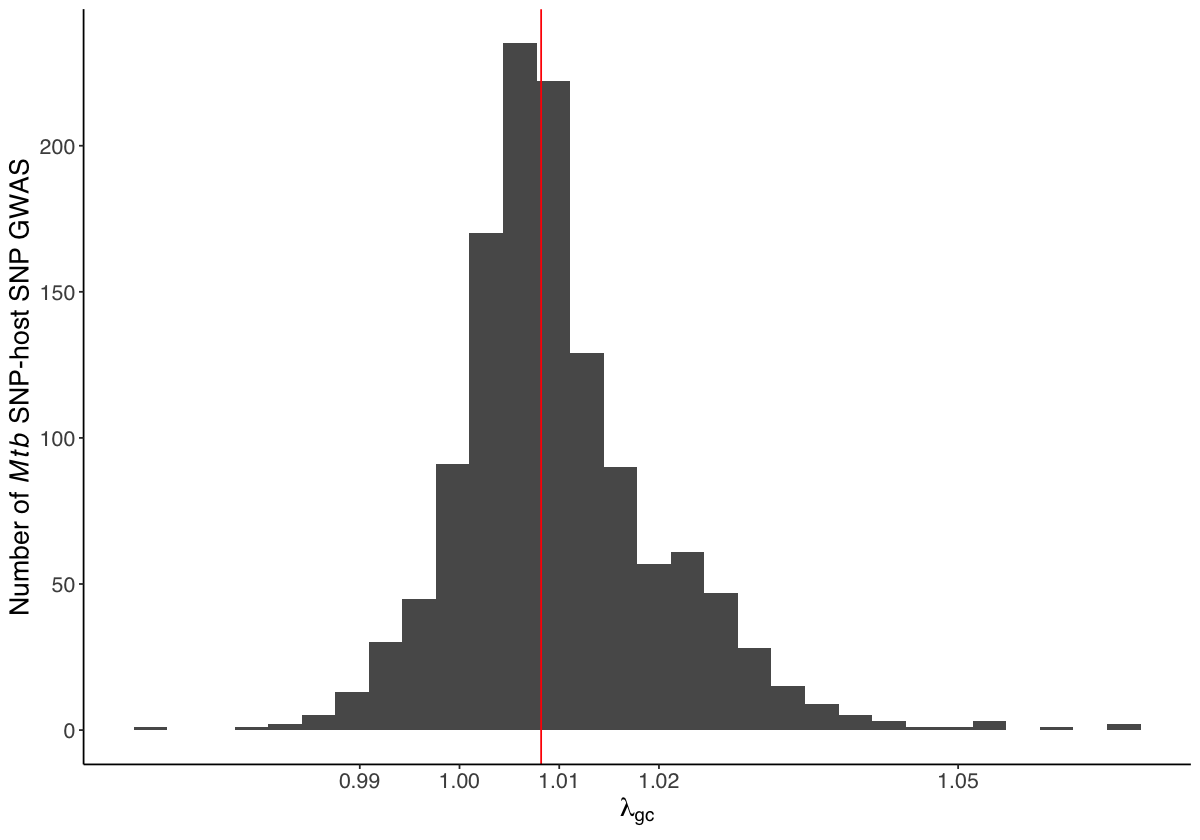

In [12]:
lambdaHist + geom_vline(aes(xintercept = median(lambdagc$V2)),col='red') +
scale_x_continuous(breaks = c(0.99,1,1.01,1.02,1.05))

ggsave("../figures/SF1_lambdagc.pdf",width=9,height=6)

# permutation p-value threshold

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


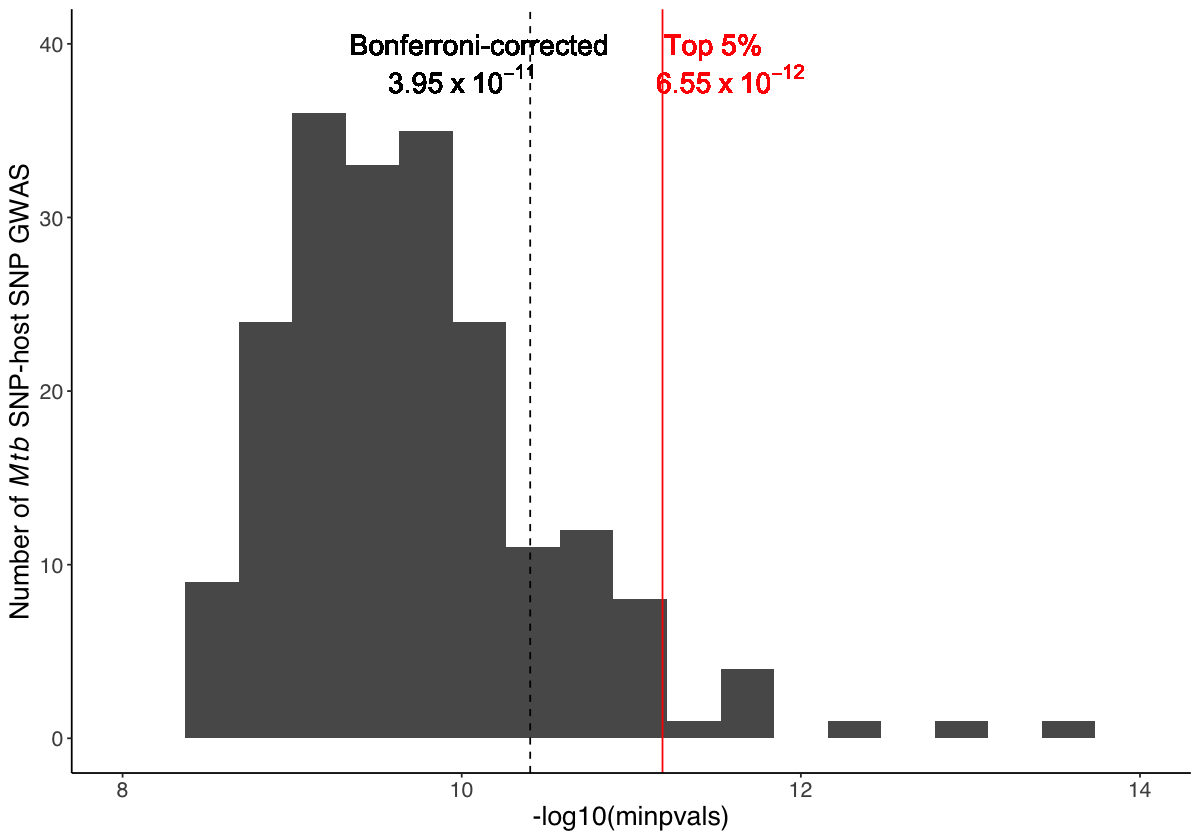

In [13]:
minpvals <- scan("../data/perm-pvals.txt",as.numeric())
bonf <- 5e-8/1267

threshold <- minpvals[order(minpvals)][length(minpvals)*0.05]

a <- 40

perm.plt <- ggplot(data.frame(minpvals),aes(-log10(minpvals))) + geom_histogram(bins=20) +
    geom_vline(aes(xintercept = -log10(threshold)), colour="red") +
    geom_text(x=-log10(threshold)+.3,y=a,label="Top 5%",size=6,col="red") +
    geom_text(x=-log10(threshold)+.4,y=a-2,label=expression(6.55~x~10^{-12}),size=6,col="red")+
    geom_vline(aes(xintercept = -log10(bonf)), colour="black",linetype="dashed") +
    geom_text(x=-log10(bonf)-.3,y=a,label="Bonferroni-corrected",size=6) +
    geom_text(x=-log10(bonf)-.4,y=a-2,label=expression(3.95~x~10^{-11}),size=6)+
    xlim(8,14) + ylim(0,a) +
    ylab(expression(paste("Number of ", italic(Mtb), " SNP-host SNP GWAS"),sep=""))

perm.plt
ggsave("../figures/SF2_permutation_pvals.pdf",width=9,height=6)

# P-P plot eQTL versus g2g pvals

In [41]:
pos <- read.table("~/Downloads/hglft_genome_1c558_76d720.bed",h=F,stringsAsFactors = F)
dim(pos)
dim(gwas)
gwas$id <- paste("6:",pos$V3,sep="")
head(gwas)

write.table(gwas %>% select("rs","af","beta","se","p_lrt","id"),
            "../data/MHCimp.97.assoc.txt",quote=F,row.names=F,col.names=T)

[1] 47505     3

[1] 47505    10

,rs,af,beta,se,p_lrt,id,eQTL,eQTLpval,eQTLbeta,eQTLvariant
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
1,rs1529749:6:28000361,0.078,0.004063635,0.02931610,0.95671590,6:28032583,NA,NA,NA,NA
2,rs17765491:6:28000610,0.078,0.004461182,0.02930195,0.94515570,6:28032832,NA,NA,NA,NA
3,rs17708949:6:28001003,0.063,-0.003448329,0.03118691,0.89593130,6:28033225,NA,NA,NA,NA
4,rs149941:6:28001033,0.292,0.028889080,0.01626819,0.06368949,6:28033255,NA,NA,NA,NA
5,rs149942:6:28001610,0.292,0.028889080,0.01626819,0.06368949,6:28033832,NA,NA,NA,NA
6,rs9393873:6:28002045,0.079,0.003519968,0.02913548,0.97063660,6:28034267,NA,NA,NA,NA


In [62]:
# read in gwas and eQTL summary stats
gwas <- read.table("../data/MHCimp.97.assoc.txt.gz",h=T)
eQTL <- read.table("../data/GTEx_v8_lung_eQTL_summary_stats.txt.gz",h=T)

gwas$eQTL <- eQTL[match(gwas$id,eQTL$id),]$pvalue
gwas$eQTLpval <- eQTL[match(gwas$id,eQTL$id),]$pvalue # check position and allele consistency
gwas$eQTLbeta <- eQTL[match(gwas$id,eQTL$id),]$beta # check position and allele consistency

gwas$eQTLvariant <- eQTL[match(gwas$id,eQTL$id),]$variant

df <- na.omit(gwas) # only plotting overlap variants between two datasets

dim(df)
df[df$p_lrt==min(df$p_lrt),]


[1] 14967    10

,rs,af,beta,se,p_lrt,id,eQTL,eQTLpval,eQTLbeta,eQTLvariant
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
12182,rs3132583:6:30688575,0.011,0.3262018,0.04120181,9.236314e-15,6:30720798,2.2168e-16,2.2168e-16,0.28213,chr6_30720798_G_C
12244,rs3130658:6:30701092,0.011,0.3262018,0.04120181,9.236314e-15,6:30733315,2.2168e-16,2.2168e-16,0.28213,chr6_30733315_C_T
12270,rs3130660:6:30706361,0.011,0.3262018,0.04120181,9.236314e-15,6:30738584,2.2168e-16,2.2168e-16,0.28213,chr6_30738584_T_A


In [63]:
y <- -log10(df$p_lrt)
x <- -log10(df$eQTLpval)

regDf <- data.frame(x=x,y=y,wght1=abs(df$beta*df$eQTLbeta))

fit <- summary(lm(y~x,data=regDf,weights=wght1))
#correlation R
sqrt(fit$r.squared)
#fit$fstatistic

#correlation p-value (in log10)
pf(fit$fstatistic[1],fit$fstatistic[2],fit$fstatistic[3],lower.tail=FALSE,log.p=TRUE)/log(10)


[1] 0.8925072

value 
-5176.906

[1] 0

Warning message:
“Ignoring unknown parameters: shape, stroke”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”


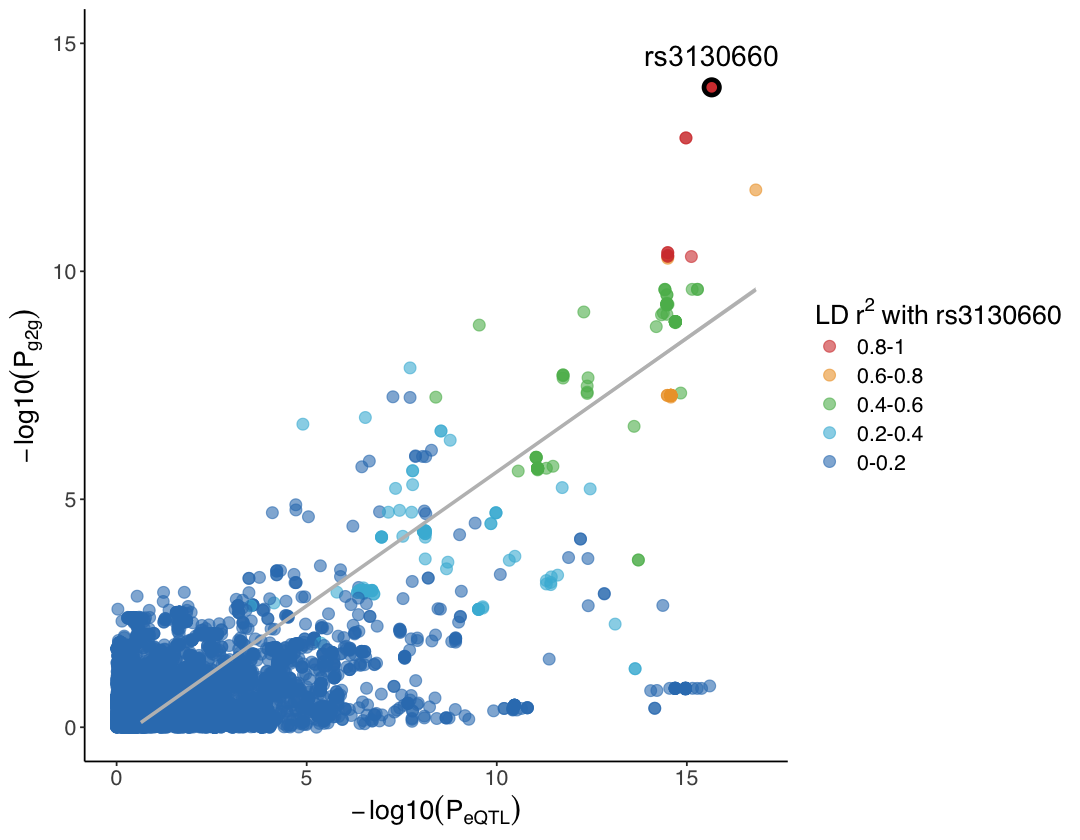

In [75]:
r2 <- read.table("../data/rs3130660_TBg2g_r2.txt.gz",h=T)
df$pos <- sapply(strsplit(as.character(df$rs), ":"), "[[", 3)

df$R2 <- 0
df$R2 <- r2[match(df$pos,r2$BP_B),]$R2
df$R2 <- ifelse(is.na(df$R2),0,df$R2)
sum(is.na(df$R2))

bins <- c(-Inf,0.2,0.4,0.6,0.8,1)

pp <- ggplot2::ggplot(data=df) +
    ggplot2::xlab((bquote(-log10(P[eQTL])))) +
    ggplot2::ylab((bquote(-log10(P[g2g])))) +
    ggplot2::theme(legend.position = "right") +
    theme(legend.spacing.y = unit(0.1, "cm")) + 
    theme(legend.key = element_rect(fill = NA, colour = NA, size = 0.25))+ylim(0,15)


pp <-  pp    +  ggplot2::geom_point(data=df,
                          aes(y=-log10(p_lrt), x=-log10(eQTLpval),color=cut(R2,bins)), size = 3)  +
      ggplot2::geom_smooth(data=df,
                           aes(y=-log10(p_lrt), x=-log10(eQTLpval),weight=abs(beta*eQTLbeta)), color = "grey", method = "lm", formula = (y ~ x)) 


signfSNP <- 'rs3130660:6:30706361'

options(repr.plot.width = 9, repr.plot.height = 7)

r2col <- (c('#D43F3A99','#EEA23699','#5CB85C99','#46B8DA99','#357EBD99'))

pp  <- pp +  scale_color_manual(bquote("LD" ~ r^2 ~ "with" ~{.("rs3130660")}), 
                          values = rev(c("(-Inf,0.2]" = r2col[5],
                                    "(0.2,0.4]"= r2col[4],
                                    "(0.4,0.6]" = r2col[3],
                                    "(0.6,0.8]" = r2col[2],
                                    "(0.8,1]" = r2col[1])),
                        label=rev(c("0-0.2","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1")))

pp <- pp + geom_point(df %>% filter(rs==signfSNP),
               mapping= aes(y=-log10(p_lrt), x=-log10(eQTLpval)),
               colour="black",shape=1,size=3,stroke=2)

pp <- pp + geom_text(df %>% filter(rs==signfSNP),
               mapping= aes(y=-log10(p_lrt)*1.05, x=-log10(eQTLpval)),
               colour="black",shape=1,size=6,stroke=2,
              label="rs3130660") 
pp


ggsave("../figures/SF3_coloc_PP.pdf",width=9,height=6)

# coloc between 49 *cis*-genes in 108 bulk RNA-seq dataset obtain from eQTL catalog v4

In [78]:
coloc <- read.table("../data/coloc_results.txt",h=T)
head(coloc)

,RNAseq_dataset,Gene,coloc_posterior
,<fct>,<fct>,<dbl>
1,Alasoo_2018_macrophage_naive,HLA-A,0.008801835
2,Alasoo_2018_macrophage_naive,ZNRD1,0.033096163
3,Alasoo_2018_macrophage_naive,PPP1R11,0.008707314
4,Alasoo_2018_macrophage_naive,RNF39,NA
5,Alasoo_2018_macrophage_naive,TRIM31,NA
6,Alasoo_2018_macrophage_naive,TRIM40,NA


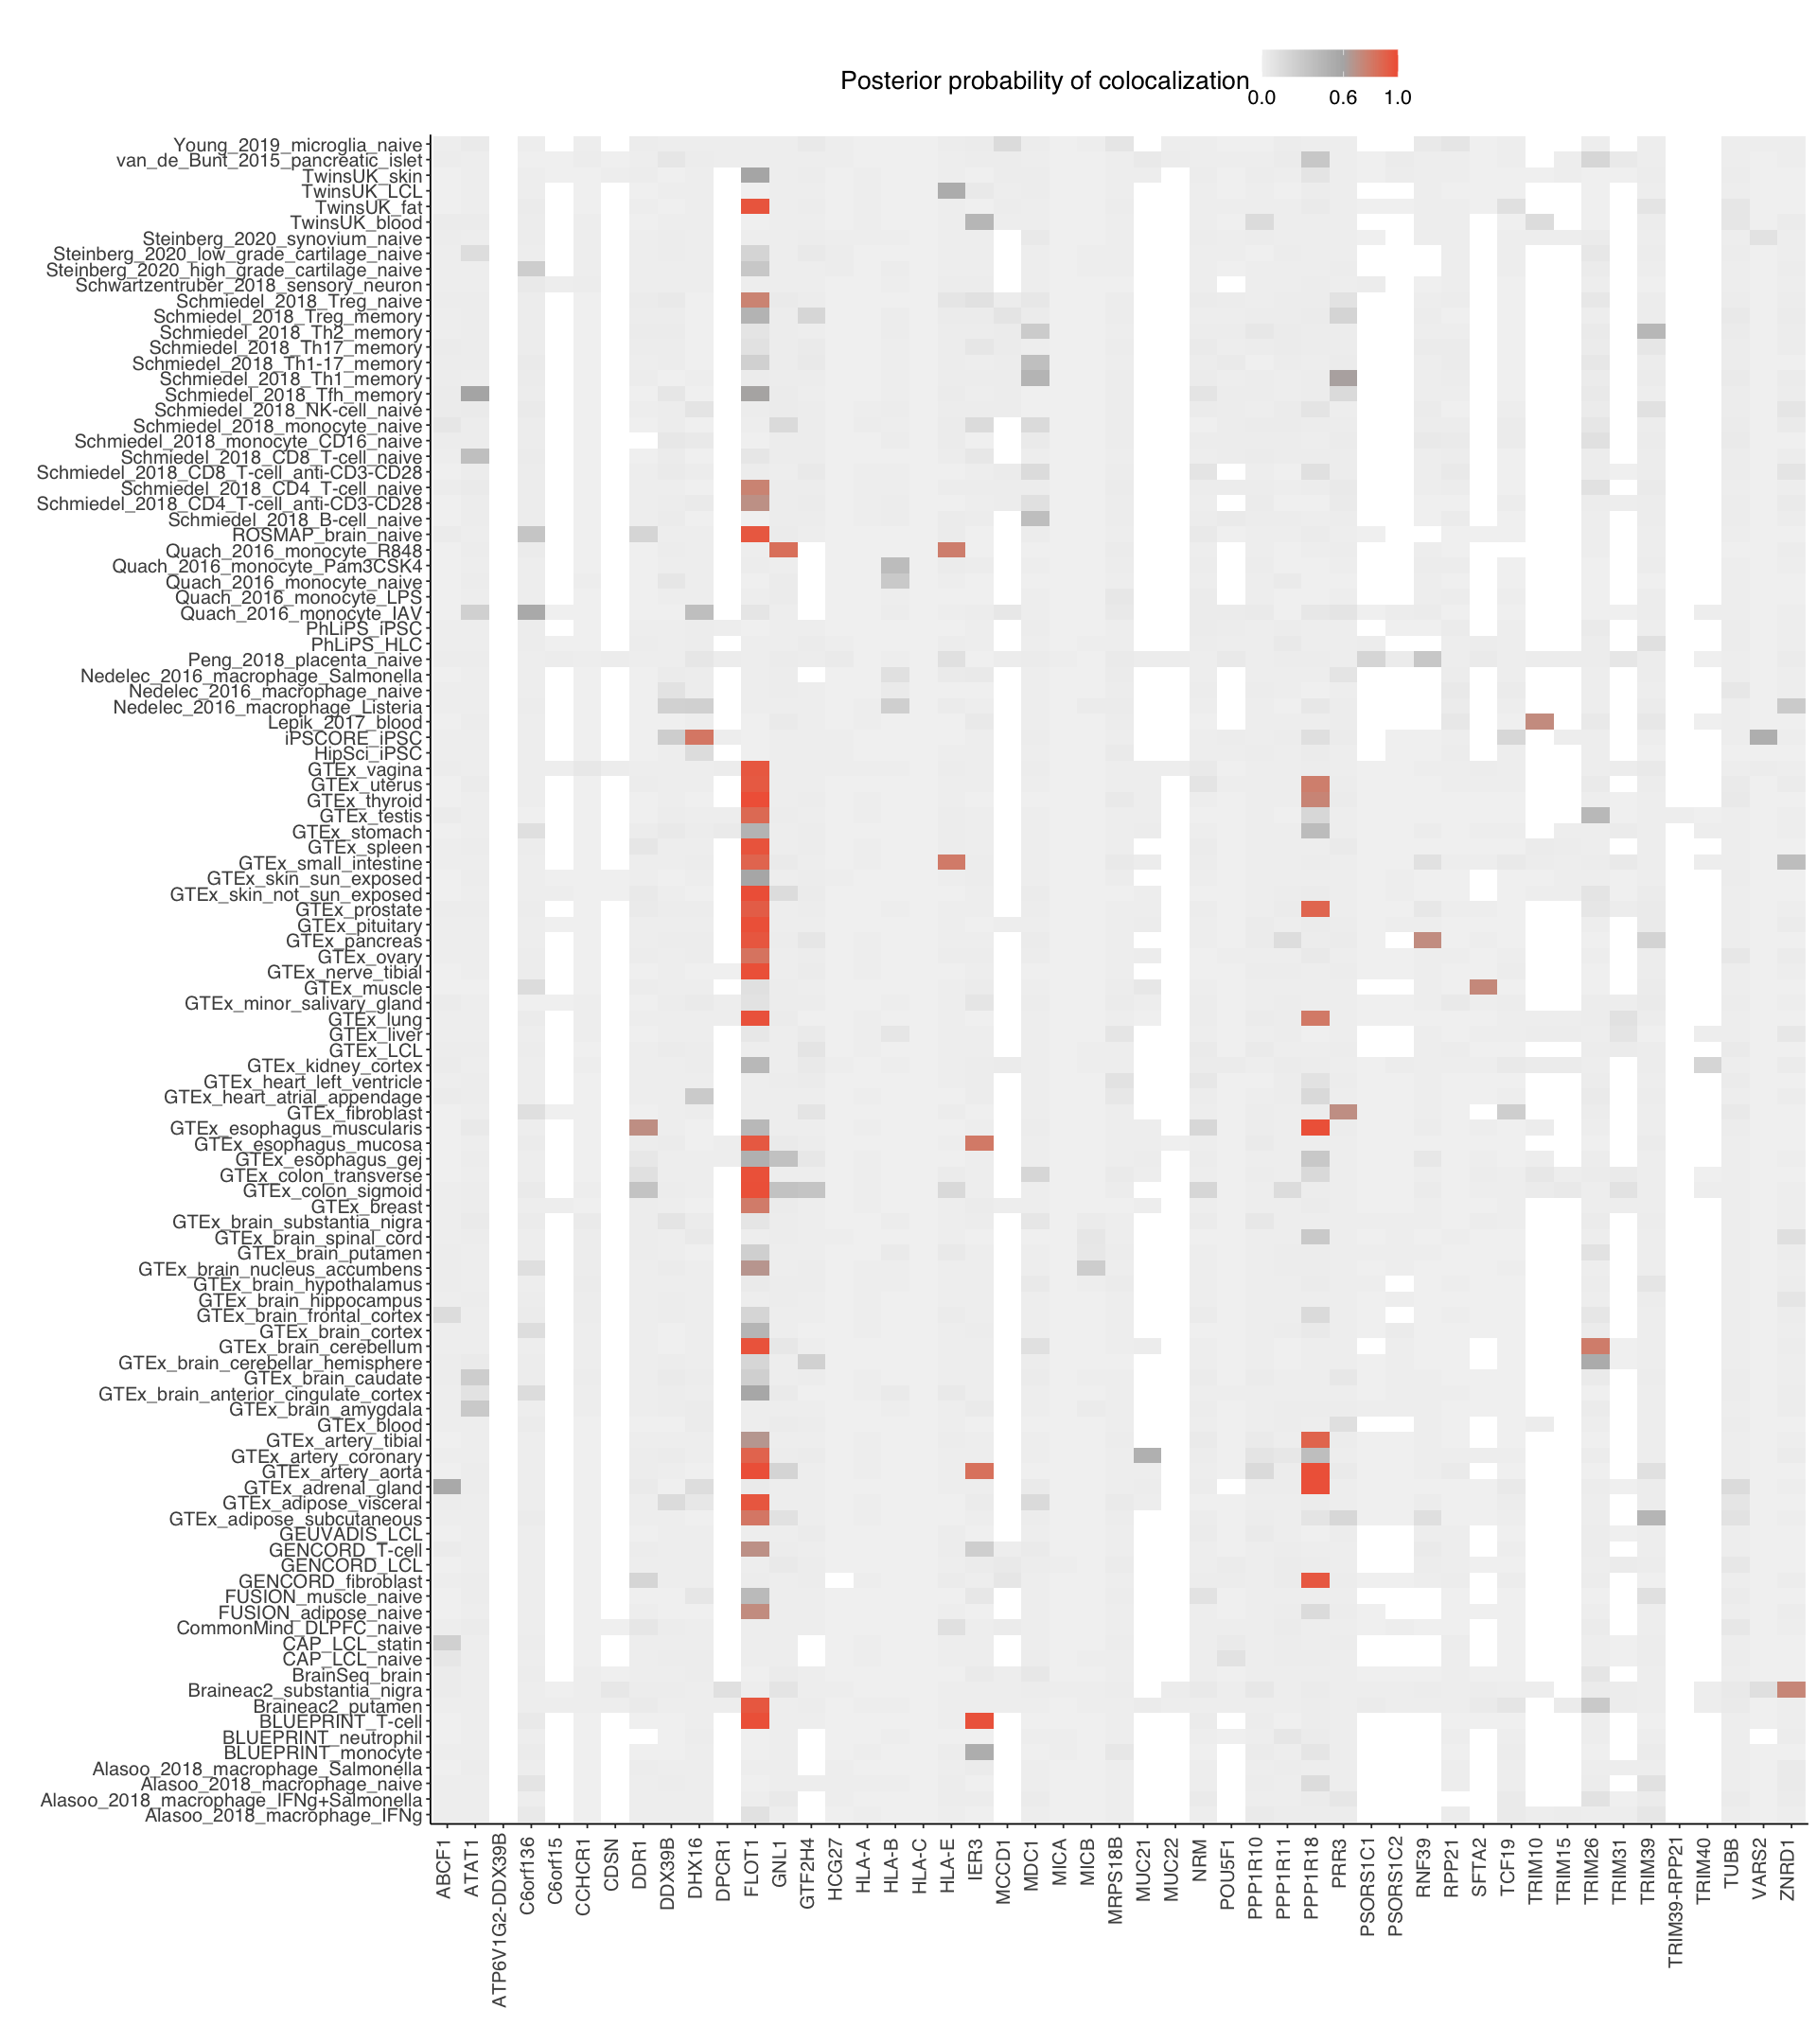

In [85]:
options(repr.plot.width = 16, repr.plot.height = 18)

Pcoloc <- ggplot(coloc, aes(x = Gene, y = RNAseq_dataset)) + 
  geom_raster(aes(fill=coloc_posterior)) + 

 scale_fill_gradient2(low = "grey95", mid = "grey70", high = "red",
                      midpoint=0.6,na.value="white",breaks=c(0,0.6,1), limits=c(0,1),
                      name="Posterior probability of colocalization")+
  labs(title="") + ylab("") + xlab("")+
   theme(legend.position="top",axis.text.x=element_text(size=12, angle=90, ,hjust=0.95,vjust=0.2),
                     axis.text.y=element_text(size=12),
                     plot.title=element_text(size=16))

Pcoloc
ggsave("../figures/SF5_coloc_all.pdf",width=18,height=20)

# conditional analysis

In [56]:
betas <- c(3.262018e-01,3.269036e-01,1.616120e-01,1.856852e-01)
ses <- c(4.120181e-02,4.117394e-02,2.729605e-02,3.012256e-02)
pvals <- c(9.236314e-15,8.349788e-15,3.419193e-09,7.756950e-10)
lmmstats  <- 
  structure(list(
    mean  = c(NA, NA, exp(betas)), 
    lower = c(NA, NA, exp(betas-ses)),
    upper = c(NA, NA, exp(betas+ses))),
    .Names = c("mean", "lower", "upper"), 
    row.names = c(NA, -6L), 
    class = "data.frame")

tabletext <- cbind(
  c("", "Covariates", "GRM, age, sex", "GRM, age, sex, year of sample collection", 
    "GRM, age, sex, \nTop 10 Mtb PCs",
                     "GRM, age, sex, \nTop 10 Mtb PCs excluding g2g-L2 variants"),
  c("","OR", signif(exp(betas),4)),
  c("","P-value", signif(pvals,4)))



In [61]:
png("../figures/SF6_conditional_analysis.png", width=12, height=8,units="cm",res=300)

forestplot(tabletext,
           lmmstats,
           new_page = TRUE,
           is.summary = c(TRUE,TRUE,rep(FALSE,4)),
        #  clip=c(-0.1,2.5),
           hrzl_lines = gpar(col = "#444444"),
           zero=1, 
           col = fpColors(box = "darkred",
                          line = "darkred"),
          txt_gp = fpTxtGp(ticks=gpar(cex=1.2), 
                        label=gpar(cex=1.5)  ))

#dev.copy(png, "SF6_conditional_analysis.png")
dev.off()

pdf 
  2

# Sampling year distribution

In [107]:
g2gyr <- read.table("../data/g2gL2_collection_year.txt",h=T)
sum(g2gyr[g2gyr$lineage=="g2g-L2",]$n)


[1] 104

,collection_year,lineage,n,perc,pos
,<fct>,<fct>,<int>,<dbl>,<dbl>
1,2011,g2g-L2,52,0.053997923,937.0
2,2011,lineage2.2,52,0.053997923,911.0
3,2011,lineage4.1,416,0.431983385,703.0
4,2011,lineage4.3,322,0.334371755,542.0
5,2011,lineage4.4,17,0.017653167,533.5
6,2011,lineage4.5,1,0.001038422,533.0


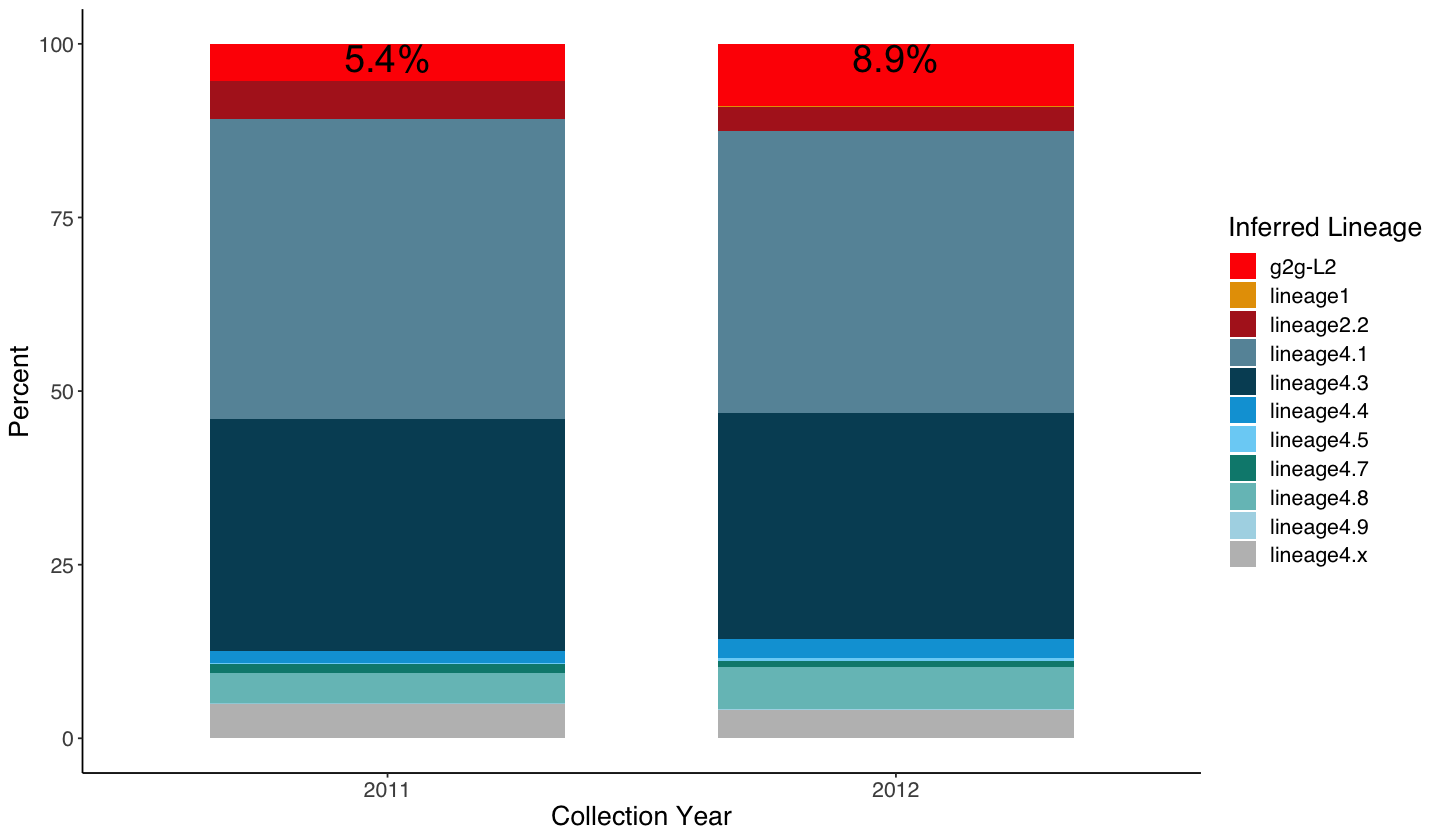

In [112]:
ggplot(g2gyr %>% filter(collection_year == "2011" | collection_year == "2012"), aes(x = factor(collection_year), y = perc*100, fill = factor(lineage))) +
  geom_bar(stat="identity", width = 0.7) +
  labs(x = "Collection Year", y = "Percent", fill = "lineage") +
    scale_fill_manual(values=c("red",lineage_colors),name="Inferred Lineage") +
      geom_text(data = g2gyr  %>% filter(collection_year == "2011" | collection_year == "2012")%>% filter(lineage=="g2g-L2"),
                aes(x = factor(collection_year),y=98,
                  label = scales::percent(perc)),size=8)

In [113]:
ggsave("../figures/SF7_collection_year.pdf",width=7,height=12)

# Host population structure

## Host PCs

In [16]:
df <- read.table("../data/host_pcs.txt",h=T)
#val <- c(46.2,24.0)
df$region <- factor(df$REGION,levels = c("AFR","EAS","EUR","AMR","SAS","LIMAA"))
pcPlt <- ggplot(df,aes(x=V3,y=V4,colour=region))+geom_point()+
  #xlab(paste("PC1 (",round(val[1],1),"%)"))+ylab(paste("PC2 (",round(val[2],1),"%)"))+
    xlab("PC1")+ylab("PC2")+
  scale_color_manual(values=pop_colors,
    name="Populations",labels = )+
  theme(legend.position="top")

## ADMIXTURE analysis

In [17]:
adm <- read.table("../data/host_admixture.txt",h=T)
table(adm$POP)
kdf5 <- adm %>% #filter(POP=="LIMA")  %>%
    mutate(id = row_number()) %>%
    gather("admixture","prop",K1,K2,K3,K4,K5) %>%
    mutate(likely_assignment = admixture[which.max(prop)],
          assignment_prob = max(prop)) %>%
    arrange(likely_assignment,desc(prop)) %>%
    ungroup() %>%
    mutate(id = fct_inorder(factor(id)))

kdf5$pop <- factor(kdf5$POP, levels=c("SAS","EAS","AFR","EUR","AMR","LIMA"))



 AFR  AMR  EAS  EUR LIMA  SAS 
 661  347  504  503 1632  489 

In [18]:
admPlt <- ggplot(kdf5, aes(x = id,y=prop,
                    fill=factor(admixture, levels = c("K5","K1","K4","K3","K2")))) +
       geom_bar(stat = "identity") +
facet_grid(~(pop),scales="free",space="free") + 
scale_fill_manual(values=pop_colors) + 
  theme(
      legend.position="none",
    panel.spacing.x = unit(0.1, "lines"),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    panel.grid = element_blank()
  ) +
ylab("Ancestry propotion") + xlab("")

## combined plot

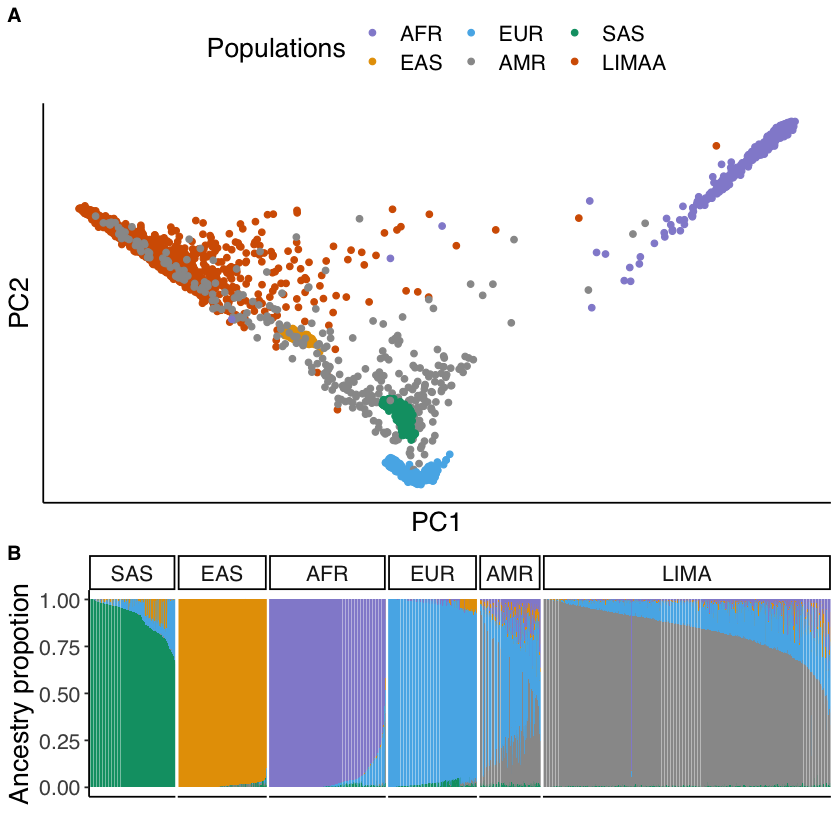

In [20]:
options(repr.plot.width = 7, repr.plot.height = 7)

ggdraw() +
  draw_plot(pcPlt+ theme(legend.position="top",    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank()), x = 0, y = .35, width = 1, height = .65) +
  draw_plot(admPlt, x = 0, y = 0, width = 1, height = .35) +
  draw_plot_label(label = c("A", "B"), size = 12,font="bold",
                  x = c(0, 0), y = c(1, .36)) +
 theme(plot.background = element_rect(fill="white", color = NA))



In [128]:
ggsave("../figures/SF9_human_pop_structure.pdf",width=8,height=10)

# *Mtb* population structure

In [132]:
Mytree <- read.tree("../data/all_tree.tre")

## read the sampling information data set
info_all <- read.table("../data/g2g_info_with_geno.txt",h=T)


## phylogeny tree with inferred sublineages


In [138]:
info <- info_all %>% filter(passg2gQC==1) 
table(info%>% select(final_lineage))

x <- as_tibble(Mytree)

oldlabel <- (Mytree$tip.label)
newlabel <- sapply(oldlabel,function(s){unlist(strsplit(s,"_"))[1]})
length(newlabel)

dim(x %>% filter(!is.na(label)))
                   
Mytree$tip.label <- newlabel



  L1   L2 L4.1 L4.3 L4.4 L4.5 L4.7 L4.8 L4.9 L4.x 
   1  178  633  516   31    3   17   79    0   98 

[1] 1602

[1] 1602    4

In [144]:
# basic tree with lineage info
tip <- as.character(info$Name)
Mytree
cleanTree <- keep.tip(Mytree, tip)

pcirc <- ggtree(cleanTree, branch.length='none',layout="circular")
p <- pcirc %<+%  info + geom_tippoint(aes(color=final_lineage),size=3) #+ geom_tiplab()

treePlt <- p + scale_color_manual(name="Inferred Lineage",values=lineage_colors) +
  theme(
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "transparent",colour = NA),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  guides(color = guide_legend(override.aes = list(size = 3)))



Phylogenetic tree with 1602 tips and 1601 internal nodes.

Tip labels:
  Peru6524, Peru7495, Peru7154, Peru7807, Peru5247, Peru6081, ...

Rooted; includes branch lengths.

## Inferred lineage percentage

In [171]:
LineageCount <- data.frame(table(info$final_lineage))
LineageCount$prop <- round(LineageCount$Freq/nrow(info) * 100,1)
LineageCount <- LineageCount %>%
  arrange(desc(Var1)) %>%
  mutate(lab.ypos = cumsum(prop) - 0.5*prop)

# donut plot
propPlt <- ggplot(LineageCount, aes(x = 2, y = prop, fill = Var1)) +
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0)+
  geom_text(aes(y = lab.ypos, label = prop), color = "white",size=5)+
  scale_fill_manual(name="Inferred Lineage",values = lineage_colors) +
  theme_void()+
  xlim(0.5, 2.5)

propPlt <- propPlt + theme(legend.text = element_text(size=20),
                          legend.title = element_text(size=20))

## combined plot

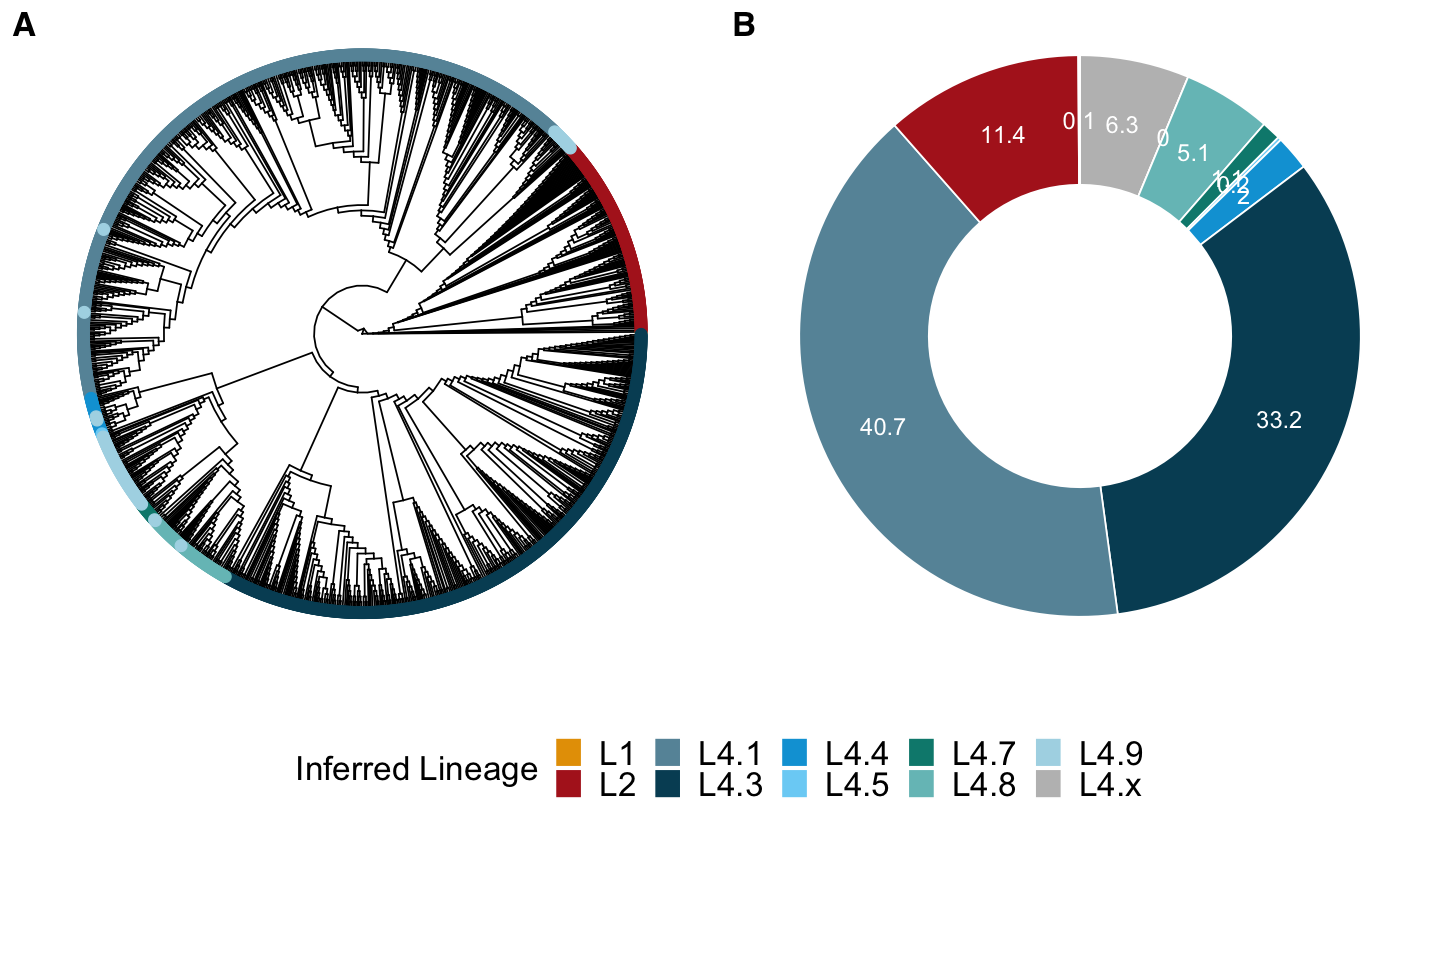

In [174]:

options(repr.plot.width = 12, repr.plot.height = 8)

# extract a legend that is laid out horizontally
legend_b <- get_legend(
  propPlt + 
    guides(color = guide_legend(nrow = 2)) +
    theme(legend.position = "bottom")
)


ggdraw() +
  draw_plot(treePlt + theme(legend.position="none"), x = 0, y = 0.2, width = .5, height = .9) +
  draw_plot(propPlt + theme(legend.position="none"), x = .5, y = 0.2, width = .5, height = .9) +
  draw_plot(legend_b, x=0.1,y=0.1,width=.8,height=0.2) + 
  draw_plot_label(label = c("A", "B"), size = 20,font="bold",
                  x = c(0, 0.5), y = c(1, 1))


In [175]:
ggsave("../figures/SF10_Mtb_pop_structure.pdf",width=12,height=8)

# L2/L4 GWAS

## Manhattan

In [262]:
gwasResults <- read.table("../data//LineageAssoc.txt.gz",h=F)
lineageMHC <- read.table("../data/MHCimp.lineage.assoc.txt.gz",h=T)

# annotate basepair position
mhc <- lineageMHC %>%
  mutate(ps = str_split(rs, ":", simplify = TRUE)[, 3])

#define cosumized plots
names(gwasResults) <- c("CHR","BP","Z","pval")

gwasResults$P <- mhc[match(gwasResults$BP,mhc$ps),]$p_lrt

gwasResults$P <- ifelse(is.na(gwasResults$P) | gwasResults$CHR!=6, gwasResults$pval,gwasResults$P)



In [265]:


don <- gwasResults %>% filter(CHR<=23) %>%
  
  # Compute chromosome size
  group_by(CHR) %>% 
  summarise(chr_len=max(as.numeric(BP))) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(gwasResults, ., by=c("CHR"="CHR")) %>%
  
  # Add a cumulative position of each SNP
  arrange(CHR, BP) %>%
  mutate( BPcum=BP+tot)

axisdf = don %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

# the observed counts
lineageGWAS <- ggplot(don %>% na.omit(), aes(x=BPcum, y=-log10(P))) +
    
    # Show all points
    geom_point( aes(color=as.factor(CHR)), alpha=0.8, size=1) +
    scale_color_manual(values = rep(c("grey","darkblue"), 23 )) +
    
    # custom X axis:
    scale_x_continuous( label = axisdf$CHR, breaks= axisdf$center ) +
    #scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis

    xlab("Chromosome") + ylab("-log10(P)") + ylim(0,9) +
  
    # Custom the theme:
    theme( 
      legend.position="none",
      panel.border = element_blank()
    )

lineageGWAS <- lineageGWAS + geom_hline(yintercept=-log10(5e-8), linetype="dashed", color = "red")

## genome-wide inflation factor lambdagc

In [267]:
#' Create a quantile-quantile plot with ggplot2.
#'
#' Assumptions:
#'   - Expected P values are uniformly distributed.
#'   - Confidence intervals assume independence between tests.
#'     We expect deviations past the confidence intervals if the tests are
#'     not independent.
#'     For example, in a genome-wide association study, the genotype at any
#'     position is correlated to nearby positions. Tests of nearby genotypes
#'     will result in similar test statistics.
#'
#' @param ps Vector of p-values.
#' @param ci Size of the confidence interval, 95% by default.
#' @return A ggplot2 plot.
#' @examples
#' library(ggplot2)
#' gg_qqplot(runif(1e2)) + theme_grey(base_size = 24)
gg_qqplot <- function(ps, ci = 0.95) {
  n  <- length(ps)
  df <- data.frame(
    observed = -log10(sort(ps)),
    expected = -log10(ppoints(n)),
    clower   = -log10(qbeta(p = (1 - ci) / 2, shape1 = 1:n, shape2 = n:1)),
    cupper   = -log10(qbeta(p = (1 + ci) / 2, shape1 = 1:n, shape2 = n:1))
  )
  log10Pe <- expression(paste("Expected -log"[10], plain(P)))
  log10Po <- expression(paste("Observed -log"[10], plain(P)))
  ggplot(df) +
    geom_ribbon(
      mapping = aes(x = expected, ymin = clower, ymax = cupper),
      alpha = 0.1
    ) +
    geom_point(aes(expected, observed), size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    # geom_line(aes(expected, cupper), linetype = 2, size = 0.5) +
    # geom_line(aes(expected, clower), linetype = 2, size = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)
}

In [268]:
lambdagc <- median(gwasResults$Z^2,na.rm=T)/qchisq(0.5,1)

Lineagelambdagc <- gg_qqplot(gwasResults$P) +
  theme(
    axis.ticks = element_line(size = 0.5),
    panel.grid = element_blank()
    # panel.grid = element_line(size = 0.5, color = "grey80")
  )
options(repr.plot.width=5, repr.plot.height=5)
Lineagelambdagc <- Lineagelambdagc + annotate("text",x=1,y=9,label=paste("~lambda[gc]==", round(lambdagc,2)),parse=T,size=6)

## MHC region only

In [244]:
mhc_manhattan <- function(gwas=gwas,snpsOfInterest=NULL,cols = c(brewer.pal(6, 'Set1'), '#777777')){
    
    #assigning to HLA genes
    gwas$GENE<-"other"

    match_index<-function(gene='A',data=gwas,buffer=500){

       # patterns <- c(paste("SNPS",gene,sep="_"), paste("HLA",gene,sep="_"), paste("AA",gene,sep="_"))

        matches <- unique (c(grep(paste("SNPS",gene,sep="_"), gwas$SNP,value=FALSE),
                          grep(paste("HLA",gene,sep="_"), gwas$SNP,value=FALSE),
                            grep(paste("AA",gene,sep="_"), gwas$SNP,value=FALSE)))

        idx <- gwas$BP>=(gwas[matches[1],]$BP-buffer) & 
                          gwas$BP<=(gwas[matches[length(matches)],]$BP+buffer)
        return(idx)
    }

    genes<-c("A","B","C","DQA1","DQB1","DRB1")

    for (gene in genes){
        gwas[match_index(gene=gene,buffer=5000),]$GENE<-gene
    }

    snpsOfInterest<-gwas[gwas$P==min(gwas$P),]$SNP

    for (gene in genes){
    df<-gwas[gwas$GENE==gene,]
    snpsOfInterest<-c(snpsOfInterest,df[df$P==min(df$P),]$SNP[1])
    }

    # Prepare the dataset
    don <- gwas %>% 
  
      # Compute chromosome size
      group_by(CHR) %>% 
      summarise(chr_len=max(BP)) %>% 
  
      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%
  
      # Add this info to the initial dataset
      left_join(gwas, ., by=c("CHR"="CHR")) %>%
  
      # Add a cumulative position of each SNP
      arrange(CHR, BP) %>%
      mutate( BPcum=BP+tot) %>%

      # Add highlight and annotation information
      mutate( is_highlight=ifelse(SNP %in% snpsOfInterest, "yes", "no")) %>%
      mutate( is_annotate=ifelse(SNP %in% snpsOfInterest, "yes", "no"))
    
    # Make the plot
    plt<-ggplot(don, aes(x=BPcum/1e6, y=-log10(P), color=GENE)) +
        # Show all points
        geom_point()+
        xlab("Chromosome 6 Position (Mb)")+ ylab('-log10(P)')+
        geom_hline(yintercept=7.5,color="red",linetype="dashed")+
    # Add highlighted points
        geom_point(data=subset(don, is_highlight=="yes"), size=2) +

        # Add label using ggrepel to avoid overlapping
        scale_color_manual("HLA gene", values = cols )
    return(plt) 
}

In [245]:
lineageMHC <- read.table("../data/MHCimp.lineage.assoc.txt.gz",h=T)

names(lineageMHC) <- c("SNP","AF","BETA","SE","P")

lineageMHC$CHR<-6

# annotate basepair position
mhc <- lineageMHC %>%
  mutate(BP = str_split(SNP, ":", simplify = TRUE)[, 3])

mhc$BP <- as.numeric(mhc$BP)


L2MHC <- mhc_manhattan(gwas=na.omit(mhc))



## combined plot

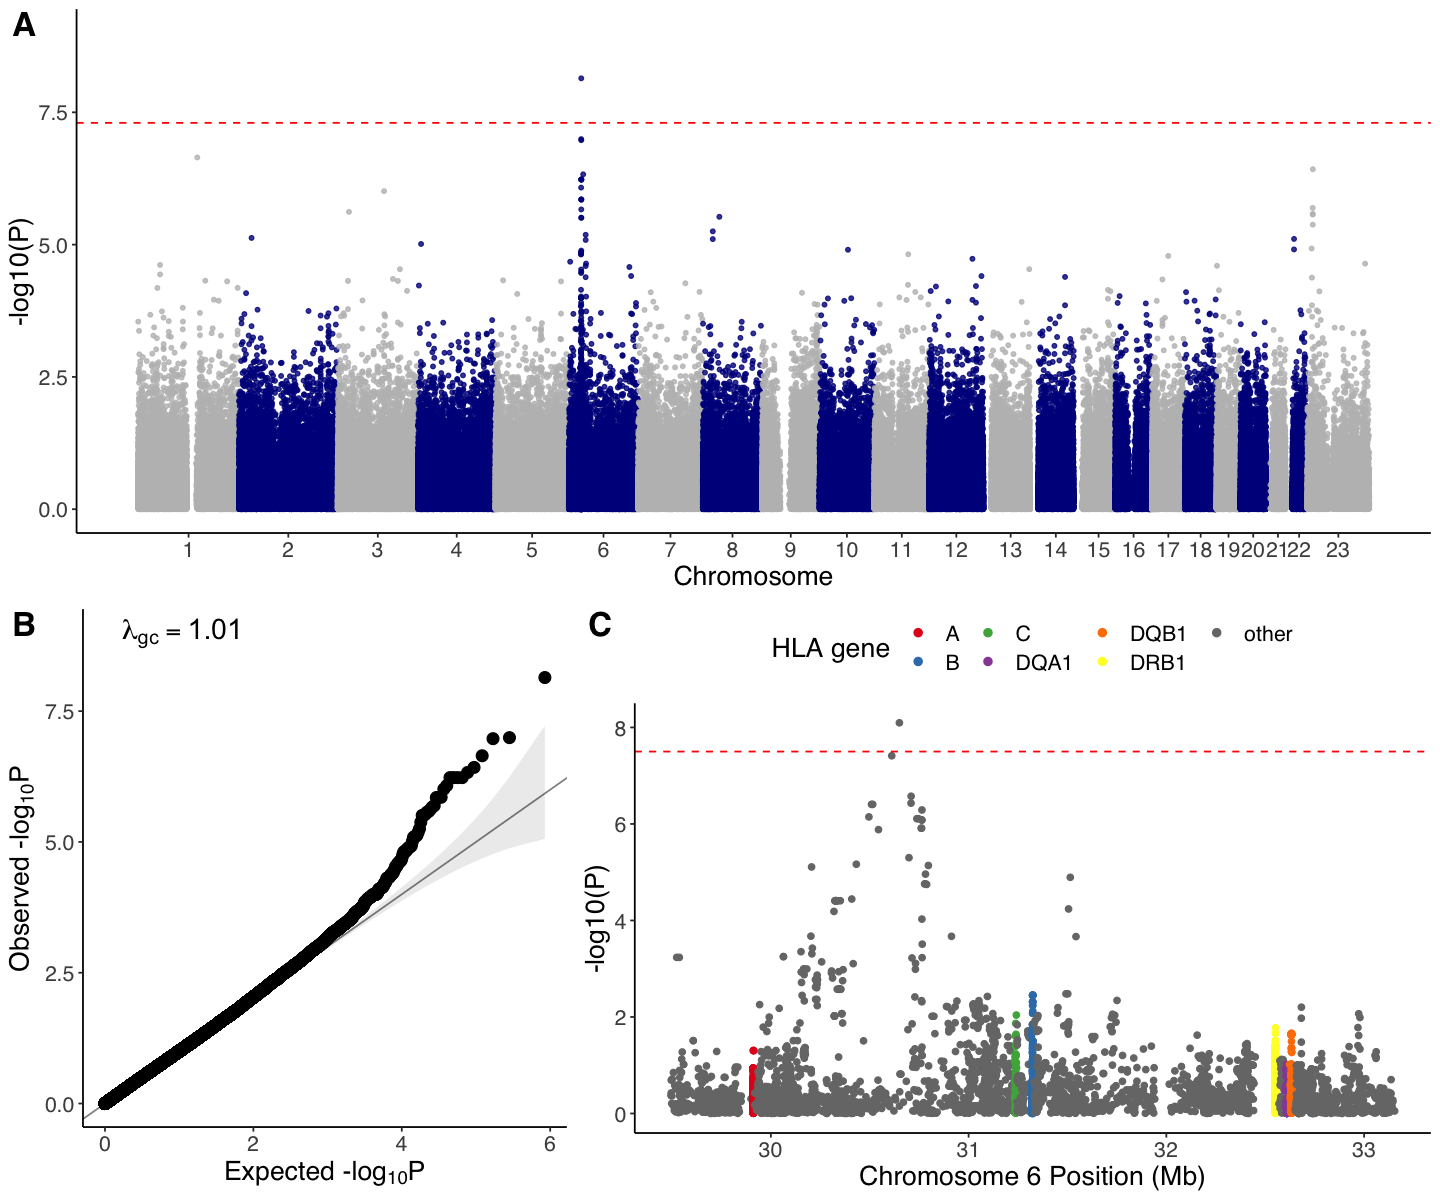

In [269]:
options(repr.plot.width = 12, repr.plot.height = 10)

ggdraw() +
  draw_plot(lineageGWAS, x = 0, y = .5, width = 1, height = .5) +
  draw_plot(Lineagelambdagc, x = 0, y = 0, width = .4, height = .5) +
  draw_plot(L4MHC + theme(legend.position = "top"), x = 0.4, y = 0, width = .6, height = 0.5) +
  draw_plot_label(label = c("A", "B", "C"), size = 20,font="bold",
                  x = c(0, 0, 0.4), y = c(1, .5, 0.5))

In [270]:
ggsave("../figures/SF11_lineage_assoc.pdf",width=12,height=10)

# global L2

In [509]:
filename <- "../data/Peru_L2_1K_1.tre"
L2tree <- ape::read.nexus(filename)
length(L2tree$tip.label)

clade <- read.table("../data/L2tree_clade_info.txt",h=F,stringsAsFactors = F)

filename <- "../data/Peru_255_ML.tre"
Peruonly <- ape::read.nexus(filename)

Perusamples <- L2tree$tip.label[L2tree$tip.label %in% Peruonly$tip.label]
length(Perusamples)

others <- L2tree$tip.label[!grepl("Peru",L2tree$tip.label) & !grepl("M00",L2tree$tip.label)]
length(others)

cleanTree <- keep.tip(L2tree, c(Perusamples,others))

length(cleanTree$tip.label)
L2info <- data.frame(Name=cleanTree$tip.label)


L2info$lineage <- "global"
L2info$lineage <- clade[match(L2info$Name,clade$V1),2]
L2info$lineage <- ifelse(grepl("Peru",cleanTree$tip.label) & !L2info$Name%in%clade$V1 , "Peru",L2info$lineage)
L2info$lineage <- ifelse(grepl("M00",cleanTree$tip.label) & !L2info$Name%in%clade$V1 , "Peru",L2info$lineage)

L2info$lineage <- ifelse(is.na(L2info$lineage),"global",L2info$lineage)

table(L2info$lineage)
sum(L2info$lineage!="global")

clade <- list(cladeA=L2info[L2info$lineage=="g2g-L2",1],
              Global=L2info[L2info$lineage=="global",1],
            cladeB=L2info[L2info$lineage=="clade-B",1],
              PL2=L2info[L2info$lineage=="Peru",1],
             cladeC=L2info[L2info$lineage=="clade-C",1])


cleanTree <- groupOTU(cleanTree,clade)

[1] 1221

[1] 199

[1] 948

[1] 1147


clade-B clade-C  g2g-L2  global    Peru 
     38      13     115     948      33 

[1] 199

In [510]:
clade_colors <- c("#E64B35FF","#4DBBD5FF","#00A087FF")

cols <- c(cladeA=clade_colors[1],cladeB=clade_colors[2],cladeC=clade_colors[3],
          PL2="#fef0d9",Global="gray30")

pcirc <- ggtree(cleanTree,layout='fan',size=.5,aes(colour=group)) + 
    scale_color_manual(values=cols,name="Strain",
                      labels=c("g2g-L2","Peru clade-B","Peru clade-C","Peru other L2","Global L2"),
                      guide=guide_legend(keywidth=.9,
                                         keyheight=2,
                                         override.aes=list(size=4,alpha=1)))+
    new_scale_color()

pcirc <- pcirc + theme( legend.title= element_text(size=16),
                      legend.text = element_text(size=16))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



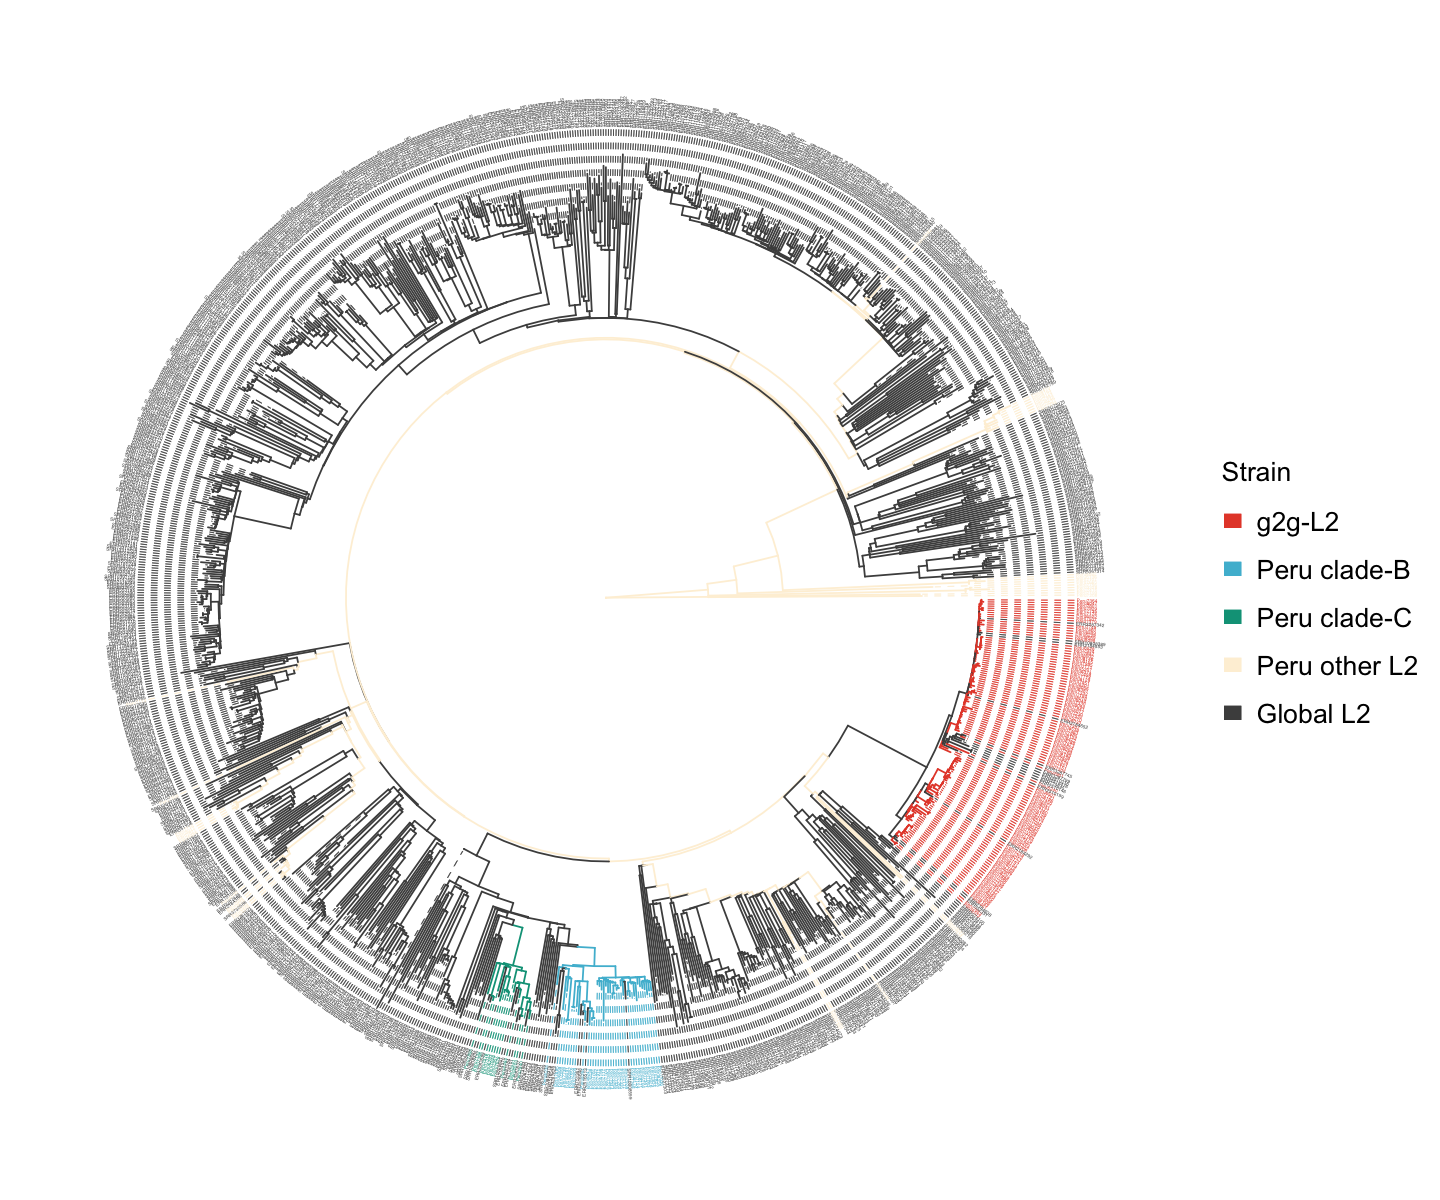

In [511]:
L2info$clade <- ifelse(L2info$lineage=="g2g-L2","cladeA",L2info$lineage)
L2info$clade <- ifelse(L2info$lineage=="clade-B","cladeB",L2info$clade)
L2info$clade <- ifelse(L2info$lineage=="clade-C","cladeC",L2info$clade)
L2info$clade <- ifelse(L2info$lineage=="Peru","PL2",L2info$clade)
L2info$clade <- ifelse(L2info$lineage=="global","Global",L2info$clade)


pcirc %<+% L2info +
    geom_tippoint(aes(color=clade),alpha=0)+
    geom_tiplab(aes(color=clade),align=TRUE,
               linetype=2, size=1,linesize=.2, show.legend=FALSE) +
    scale_color_manual(values=cols, name="",guide="none")



In [512]:
ggsave("../figures/SF12_global_L2.pdf",width=10,height=7)

# Annotation cluster

## FAD annotation cluster

In [515]:
fad <- read.table(file = "../data//DAVID_fad.txt", row.names = 1, h=T,sep="\t")


In [551]:
longData<-melt(as.matrix(fad[,-7]))


fadP <- ggplot(longData, aes(x = Var1, y = Var2)) + 
  geom_raster(aes(fill=value)) + 
  scale_fill_gradient(low="white", high="red",guide="none") +
  labs(y="", x="", title="Enrichment score = 1.03") +
  theme(axis.text.x=element_text(size=20, angle=60, vjust=1,hjust=1),
                     axis.text.y=element_text(size=20),
                     plot.title=element_text(size=20),
       panel.border = element_rect(linetype = "solid", fill = NA))


## ATP annotation cluster

In [568]:
atp <- read.table(file = "../data//DAVID_ATPase.txt", row.names = 1, h=T,sep="\t")

longData<-melt(as.matrix(atp[,-ncol(atp)]))


atpP <- ggplot(longData, aes(x = Var1, y = Var2)) + 
  geom_raster(aes(fill=value)) + 
  scale_fill_gradient(low="white", high="red",guide="none") +
  labs(y="", x="", title="Enrichment score = 1.13") +
  theme(axis.text.x=element_text(size=20, angle=60, vjust=1,hjust=1),
                     axis.text.y=element_text(size=20),
                     plot.title=element_text(size=20),
       panel.border = element_rect(linetype = "solid", fill = NA))


## combined

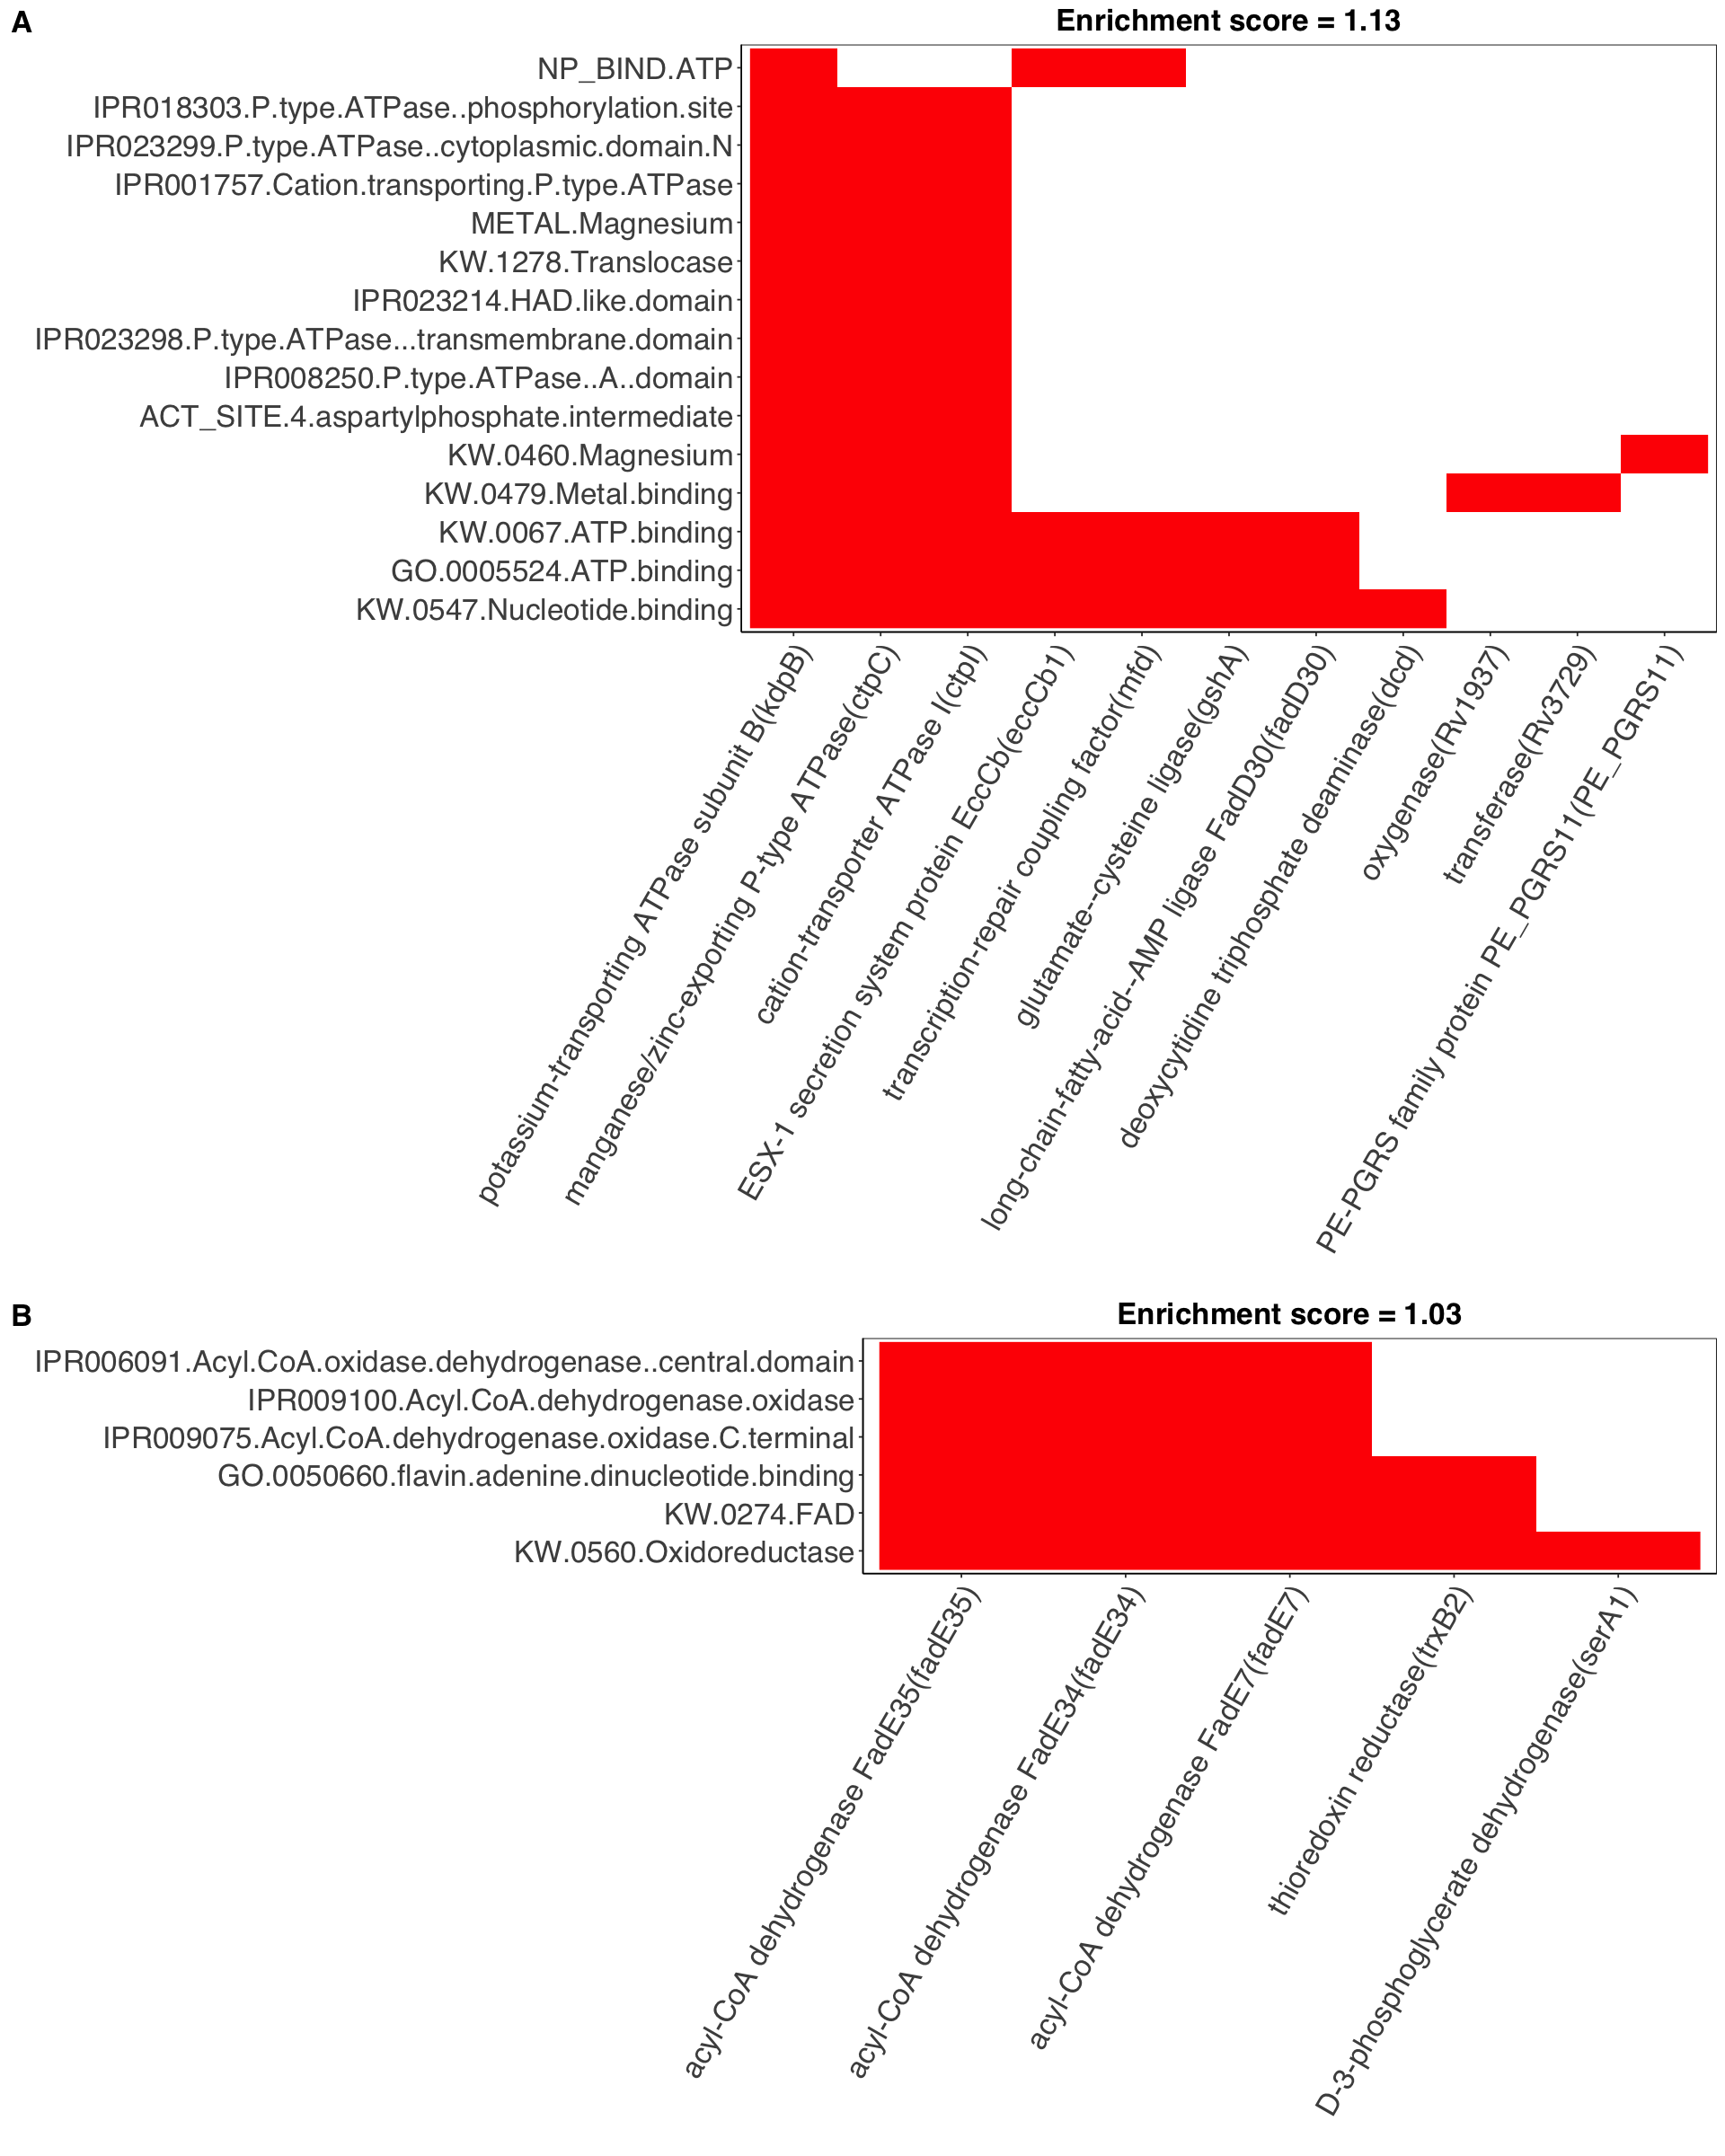

In [571]:
options(repr.plot.width = 16, repr.plot.height = 20)


ggdraw() +
  draw_plot(atpP + theme(legend.position="none"), x = 0, y = 0.4, width = 1, height = .6) +
  draw_plot(fadP + theme(legend.position="none"), x = 0, y = 0, width = 1, height = .4) +
  draw_plot_label(label = c("A", "B"), size = 20,font="bold",
                  x = c(0, 0), y = c(1, .4))
